In [44]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
import numpy as np
from glob import glob
from scipy import misc
from matplotlib.patches import Circle,Ellipse
from matplotlib.patches import Rectangle
import os
from PIL import Image

In [3]:
import tensorflow.keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import ZeroPadding2D

In [4]:
adda = sc.read_h5ad('smaller_dada.h5ad')
gene_names = adda.var.index.tolist()
row_col = adda.obs[['array_row', 'array_col']].values.astype(int)
df = pd.DataFrame(data=np.concatenate((row_col, adda.X), axis=1), columns=['row', 'col'] + gene_names)
df['row'] = df['row'].astype(int)
df['col'] = df['col'].astype(int)

RESIZE_WIDTH = 128
RESIZE_HEIGHT = 64

def resize_gene_maps(gene_map):
    img = Image.fromarray(np.uint8(gene_map * 255) , 'L')
    img = img.resize((RESIZE_WIDTH, RESIZE_HEIGHT))
    img = np.asarray(img) / 255
    return img

def min_max_scale(gm):
    not_nan_values = gm[~np.isnan(gm)]
    mx = not_nan_values.max()
    mn = not_nan_values.min()
    gm = gm - mn
    gm = gm / (mx - mn)
    return gm

def make_gene_map(gene_df, gene_name):
    gm = min_max_scale(gene_df.pivot('row', 'col', gene_name).values)
    gm[np.isnan(gm)] = 0
    gm = gm[1:-1]
    gm = np.concatenate((np.zeros([RESIZE_HEIGHT, RESIZE_WIDTH - gm.shape[1]]), gm), axis=1)
    return gm

# row_len = row_col[:, 0].max() - row_col[:, 0].min() + 1
# col_len = row_col[:, 1].max() - row_col[:, 1].min() + 1
gene_maps = np.zeros([len(gene_names), RESIZE_HEIGHT, RESIZE_WIDTH], dtype=np.float32)
for i, name in enumerate(gene_names):
    gene_maps[i] = make_gene_map(df, name)

In [5]:
gene_maps.max()

1.0

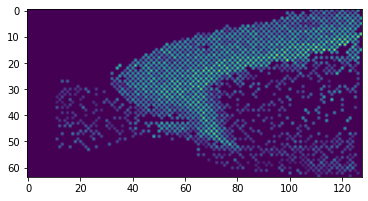

In [6]:
data = gene_maps
data1 = gene_maps[gene_names.index('Vxn')]

plt.imshow(data1)
plt.show()

In [7]:
images = gene_maps
images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')

images_arr = np.expand_dims(images_arr, -1)


In [8]:
images_arr.shape

(1500, 64, 128, 1)

In [9]:
train_X, valid_X, train_ground, valid_ground = train_test_split(images_arr,
                                                             images_arr,
                                                             test_size=0.2,
                                                             random_state=13)

In [10]:
train_X.shape

(1200, 64, 128, 1)

In [11]:
batch_size = 128
epochs = 100

inChannel = 1
x, y = train_X.shape[1], train_X.shape[2]
input_img = Input(shape = (x, y, inChannel))

In [12]:
def autoencoder(cropped):
    #encoder
    h = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(cropped)
    h = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(h)
    h = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(h)

    # decoder
    h = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(h)
    h = Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(h)
    h = Conv2DTranspose(1, (3, 3), activation='relu', padding='same', strides=(2, 2))(h)
    return h

In [13]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam(learning_rate=0.0003))

In [14]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 64, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 32, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 16, 32)         4640      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 32, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 64, 16)        4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 128, 1)        145   

In [15]:
autoencoder_train = autoencoder.fit(train_X, 
                                    train_ground, 
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(valid_X, valid_ground))

Epoch 1/100
10/10 [==============================] - 2s 95ms/step - loss: 0.0119 - val_loss: 0.0111
Epoch 2/100
10/10 [==============================] - 1s 64ms/step - loss: 0.0116 - val_loss: 0.0108
Epoch 3/100
10/10 [==============================] - 1s 67ms/step - loss: 0.0112 - val_loss: 0.0104
Epoch 4/100
10/10 [==============================] - 1s 61ms/step - loss: 0.0108 - val_loss: 0.0099
Epoch 5/100
10/10 [==============================] - 1s 63ms/step - loss: 0.0101 - val_loss: 0.0092
Epoch 6/100
10/10 [==============================] - 1s 56ms/step - loss: 0.0091 - val_loss: 0.0082
Epoch 7/100
10/10 [==============================] - 1s 62ms/step - loss: 0.0080 - val_loss: 0.0073
Epoch 8/100
10/10 [==============================] - 1s 65ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 9/100
10/10 [==============================] - 1s 66ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 10/100
10/10 [==============================] - 1s 65ms/step - loss: 0.0058 - val_loss: 0.0055

Test Images


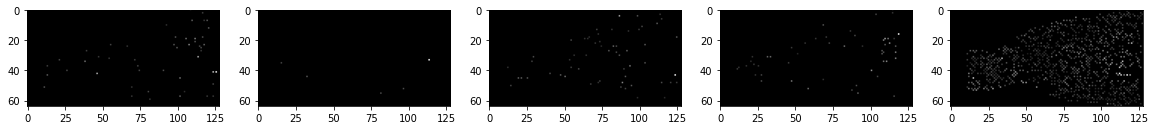

Reconstruction of Test Images


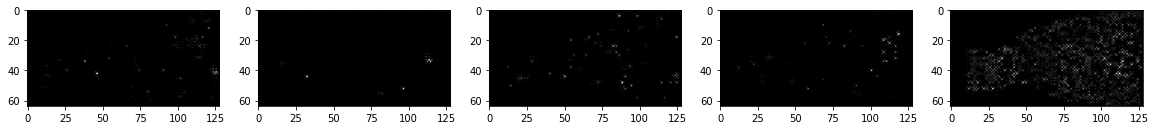

In [16]:
# %%
pred = autoencoder.predict(valid_X)


# %%

plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(valid_ground[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [18]:
intermediate_layer_model = Model(inputs=autoencoder.input,
                                       outputs=autoencoder.get_layer('conv2d_2').output)

In [19]:
x = np.expand_dims(gene_maps[1], [0, -1])
print(x.shape)
feat = intermediate_layer_model.predict(x)

(1, 64, 128, 1)


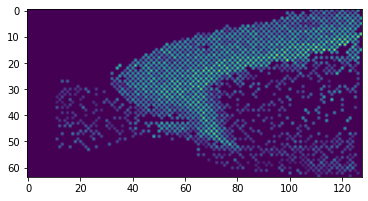

In [20]:
plt.imshow(x[0, :, :, 0])
plt.show()

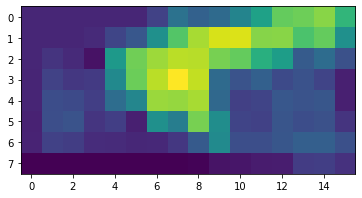

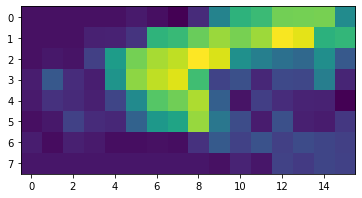

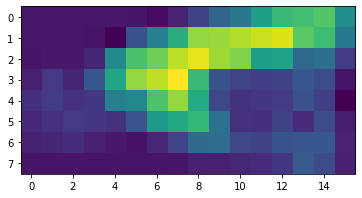

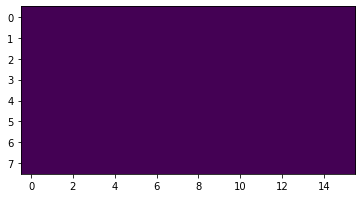

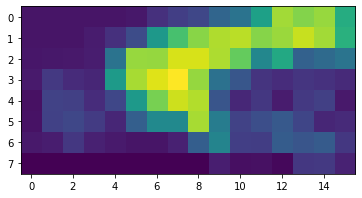

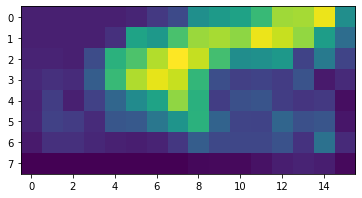

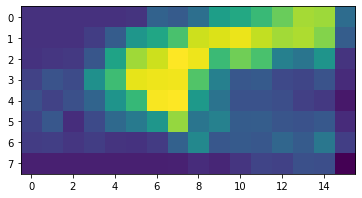

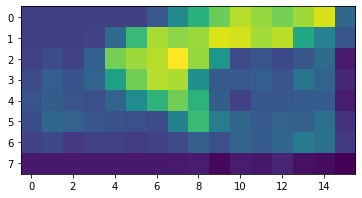

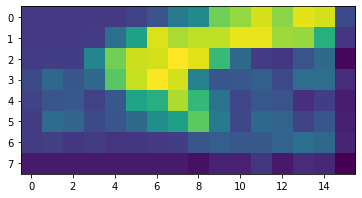

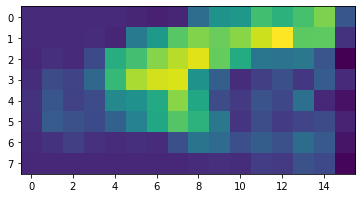

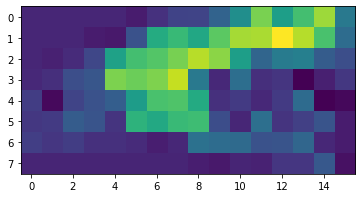

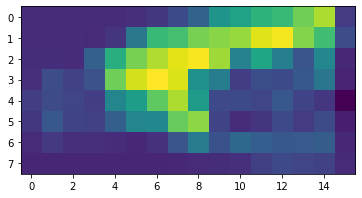

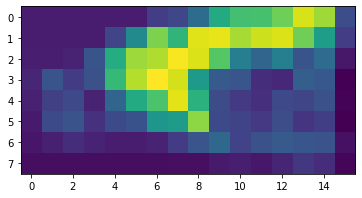

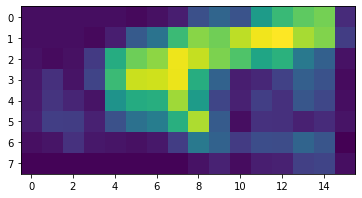

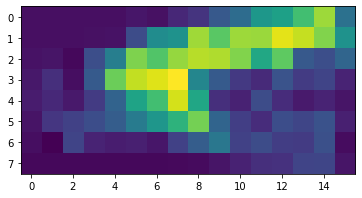

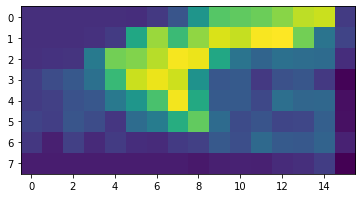

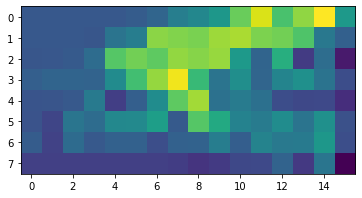

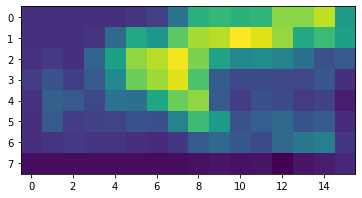

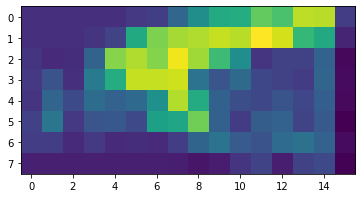

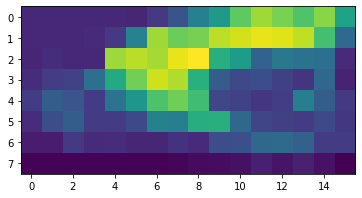

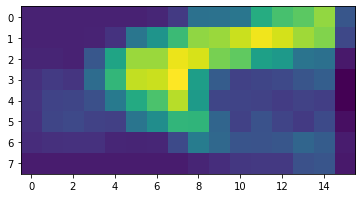

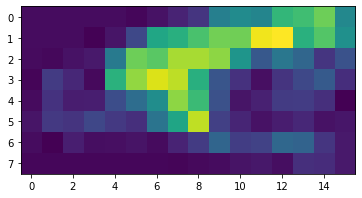

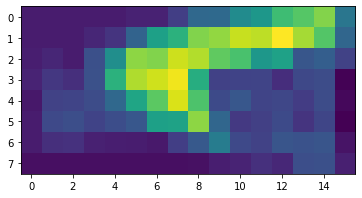

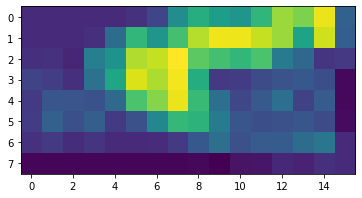

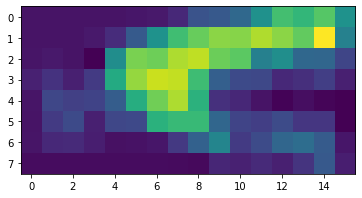

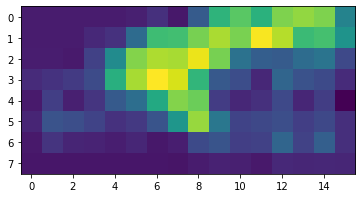

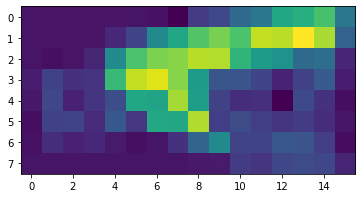

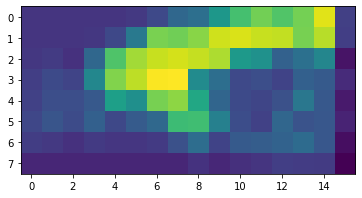

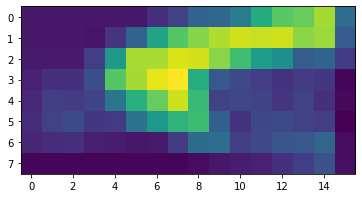

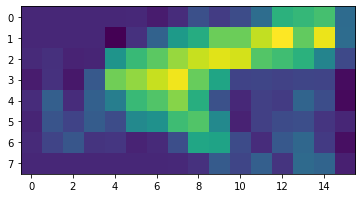

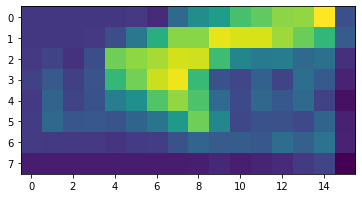

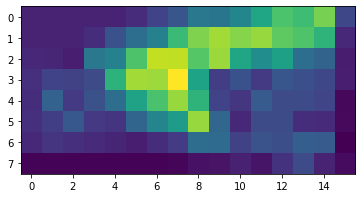

In [21]:
for i in range(32):
    plt.imshow(feat[0, :, :, i])
    plt.show()

In [22]:
def find_similar_genes(target_feat, all_features, top_k=10):
    dist = [distance.cosine(target_feat, all_features[i]) for i in range(all_features.shape[0])]
    top_k_idx = np.argsort(dist)[1:top_k+1]
    return top_k_idx

def find_similar_genes_euclidean(target_feat, all_features, top_k=10):
    dist = [np.square(target_feat - all_features[i]).sum() for i in range(all_features.shape[0])]
    top_k_idx = np.argsort(dist)[1:top_k+1]
    return top_k_idx

def find_similar_genes_dot_prod(target_feat, all_features, top_k=10):
    dist = [-1 * (target_feat * all_features[i]).sum() for i in range(all_features.shape[0])]
    top_k_idx = np.argsort(dist)[1:top_k+1]
    return top_k_idx

In [23]:
x = np.expand_dims(gene_maps, -1)
all_feats = intermediate_layer_model.predict(x)

In [24]:
all_feats = all_feats.reshape(all_feats.shape[0], -1)

In [25]:
def find_similar_genes_consine(target_feat, all_features, top_k=10):
    dist = [distance.cosine(target_feat, all_features[i]) for i in range(all_features.shape[0])]
    top_k_idx = np.argsort(dist)[1:top_k+1]
    return top_k_idx

def find_similar_genes_euclidean(target_feat, all_features, top_k=10):
    dist = [np.square(target_feat - all_features[i]).sum() for i in range(all_features.shape[0])]
    top_k_idx = np.argsort(dist)[1:top_k+1]
    return top_k_idx

def find_similar_genes_dot_prod(target_feat, all_features, top_k=10):
    dist = [-1 * (target_feat * all_features[i]).sum() for i in range(all_features.shape[0])]
    top_k_idx = np.argsort(dist)[1:top_k+1]
    return top_k_idx

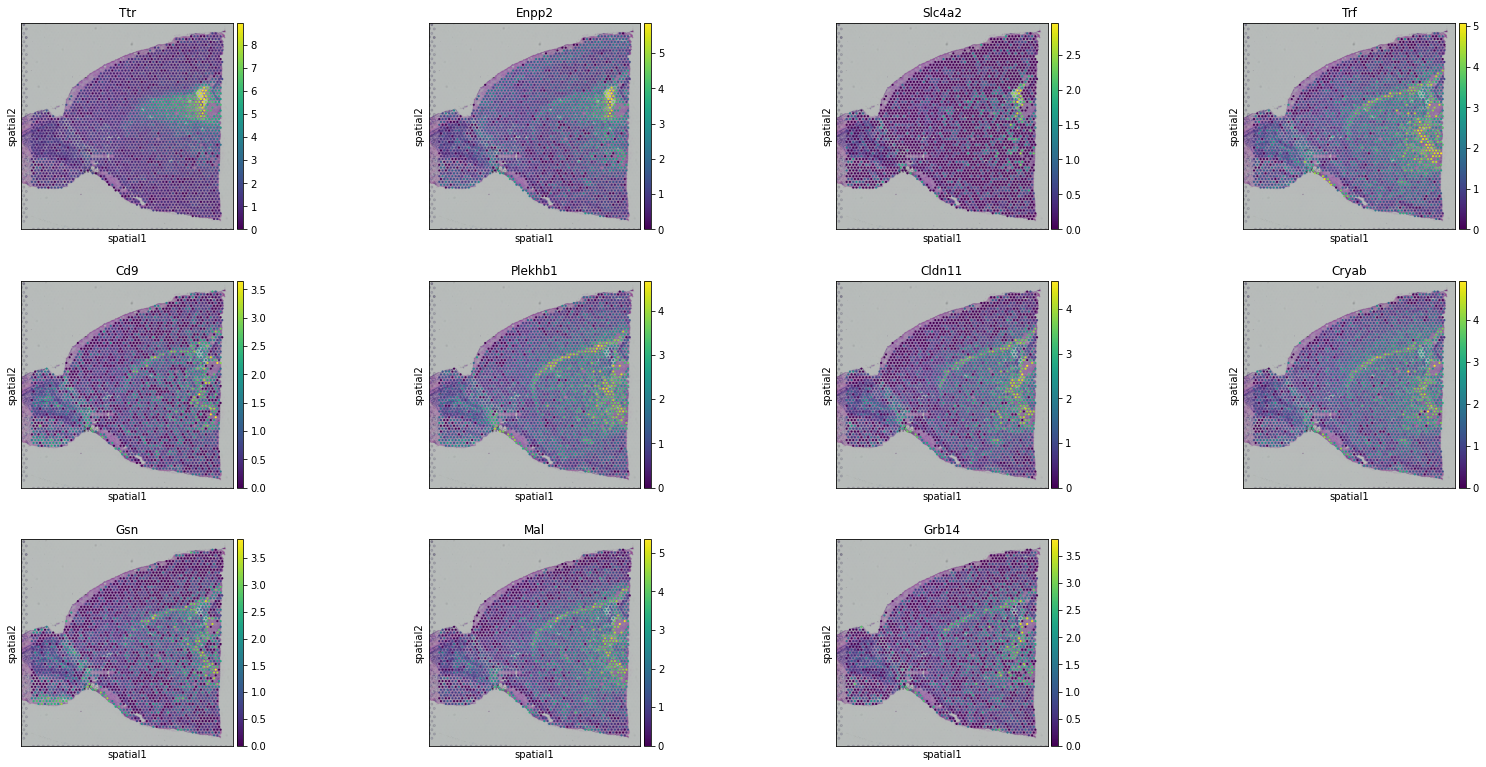

In [26]:
target_gene_name = 'Ttr'
target_gene_idx = gene_names.index(target_gene_name)
top10_genes = find_similar_genes(all_feats[target_gene_idx], all_feats)

sc.pl.spatial(adda, color=[target_gene_name] + [gene_names[i] for i in top10_genes])

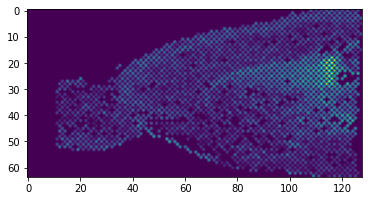

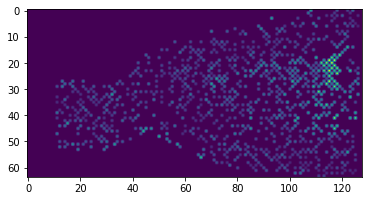

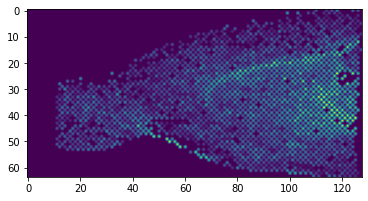

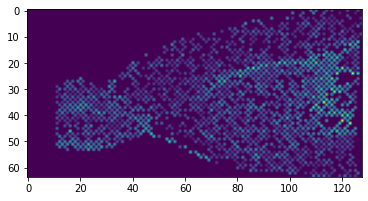

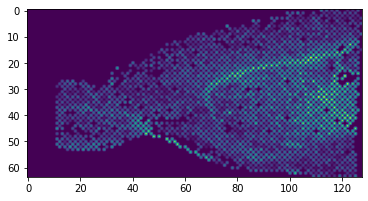

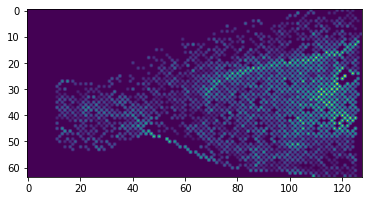

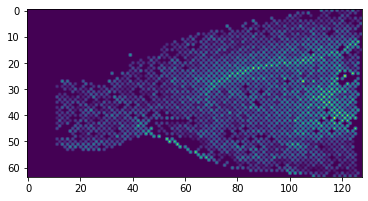

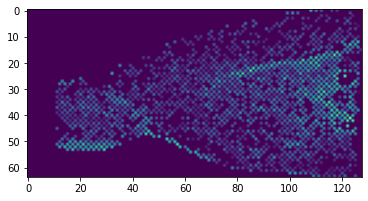

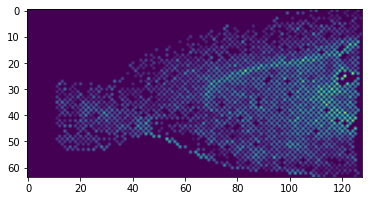

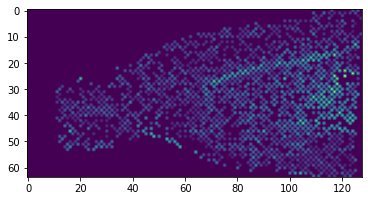

In [27]:
for idx in top10_genes:
    plt.imshow(gene_maps[idx])
    plt.show()

In [31]:
def jaccard_precision_recall(gt, pred, threshold=0.5):
    assert gt.max() <= 1 and gt.min() >= 0
    assert pred.max() <= 1 and pred.min() >= 0
    assert threshold <= 1 and threshold >= 0
    assert gt.shape[0] == pred.shape[0]
    assert gt.shape[1] == pred.shape[1]

    gt = (gt >= threshold)
    pred = (pred >= threshold)
    
    inter = (gt & pred).sum()
    gt_area = gt.sum()
    pred_area = pred.sum()
    union = gt_area + pred_area - inter
    
    if union > 0:
        jaccard = inter / union
    else:
        jaccard = 0
    if pred_area > 0:
        precision = inter / pred_area
    else:
        precision = 0

    return jaccard, precision

def jaccard_precision_curve(gt, pred, threshold_num=1000):
    threshold_list = []
    jaccard_list = []
    precision_list = []
    for th in np.linspace(0, 1, threshold_num):
        threshold_list.append(th)
        j, p = jaccard_precision_recall(gt, pred, th)
        jaccard_list.append(j)
        precision_list.append(p)

    return threshold_list, jaccard_list, precision_list



In [67]:
target_gene_name = 'Vxn'
target_gene_idx = gene_names.index(target_gene_name)
top10_genes = find_similar_genes(all_feats[target_gene_idx], all_feats)

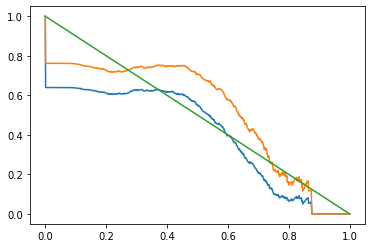

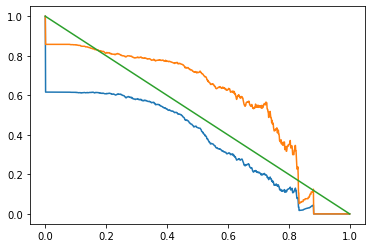

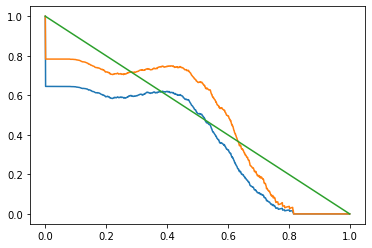

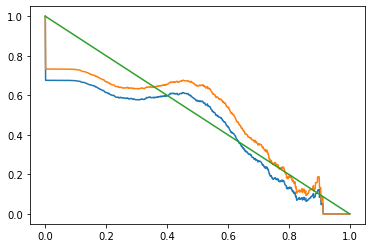

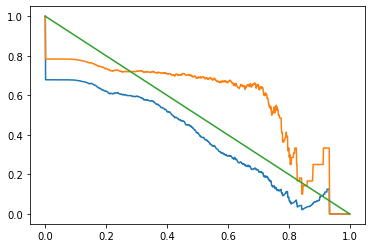

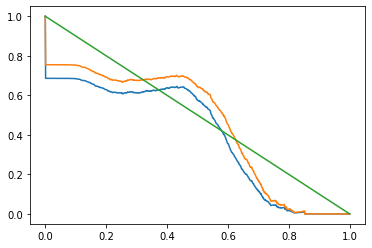

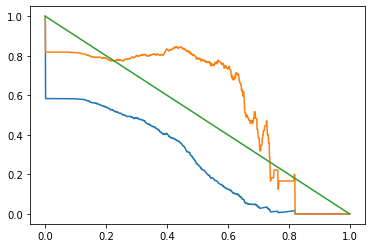

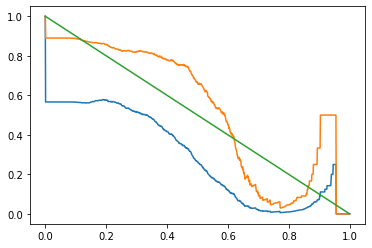

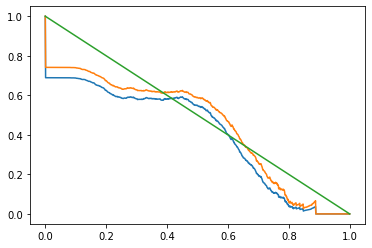

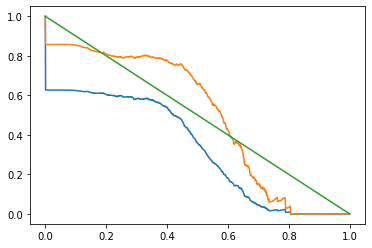

In [68]:
gt = gene_maps[target_gene_idx]
jaccard_auc_list = []
precision_auc_list = []
threshold_num = 1000
jaccard_sum = np.zeros([threshold_num])
precision_sum = np.zeros([threshold_num])

for i in top10_genes:
    pred = gene_maps[i]
    x, j, p = jaccard_precision_curve(gt, pred, threshold_num)
    jaccard_auc_list.append(metrics.auc(x, j))
    precision_auc_list.append(metrics.auc(x, p))
    
    jaccard_sum += j
    precision_sum += p

    plt.figure()
    plt.plot(x, j)
    plt.plot(x, p)
    plt.plot([0, 1], [1, 0])
    plt.show()
    
jaccard_mean = jaccard_sum / len(top10_genes)
precision_mean = precision_sum /len(top10_genes)

(0.0, 1.0)

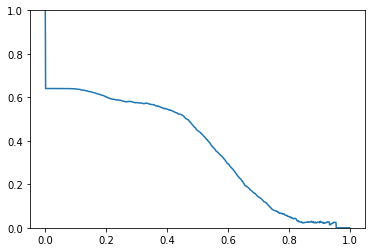

In [69]:
plt.plot(x, jaccard_mean)
plt.ylim([0, 1])

In [70]:
np.mean(jaccard_auc_list)

0.364531756980732

(0.0, 1.0)

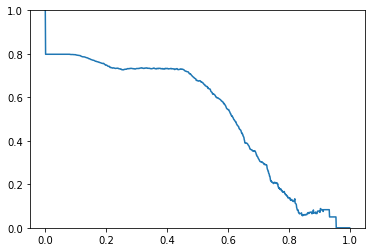

In [71]:
plt.plot(x, precision_mean)
plt.ylim([0, 1])

In [72]:
np.mean(precision_auc_list)

0.5148541674312652

In [ ]:
for th in np.linspace(0, 1, 100):
    print(th)
    print('gt')
    plt.imshow(gt >= th)
    plt.show()
    print('pred')
    plt.imshow(pred >= th)
    plt.show()